In [1]:
import os
from typing import Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Dense, Input

In [2]:
NUM_INPUTS = 96
NUM_OUTPUTS = 1
VAL_SPLIT = 0.1  # Percentage
BATCH_SIZE = 64
EPOCHS = 1
PATIENCE = 10  # Early stoping
LEARNING_RATE = 1e-4

In [3]:
def make_dataset(df: pd.DataFrame, shuffle: bool = True) -> tf.data.Dataset:
    dataset = tf.data.Dataset.from_tensor_slices(df.to_numpy())
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(lambda window: (window[:NUM_INPUTS], window[NUM_INPUTS:]))
    dataset = dataset.batch(batch_size=BATCH_SIZE, drop_remainder=False).prefetch(3)

    return dataset


def get_compiled_model(
    input_shape: Sequence[int],
    num_outputs: int,
    hidden: Sequence[int] = (100, 100, 100),
    activation: str = "relu",
    lr: float = 1e-3,
    batch_norm: bool = True,
) -> keras.Model:
    model = tf.keras.Sequential()
    model.add(Input(shape=input_shape))
    if batch_norm:
        model.add(BatchNormalization())
    for h_units in hidden:
        model.add(Dense(h_units, activation="relu"))
    model.add(Dense(num_outputs))

    model.compile(
        optimizer=keras.optimizers.Adam(lr=lr),
        loss=keras.losses.mse,
        metrics=[keras.metrics.mse],
    )

    return model


def mse(a: np.array, b: np.array) -> float:
    return np.mean(np.square(a - b))


def mae(a: np.array, b: np.array) -> float:
    return np.mean(np.abs(a - b))


def smape(a: np.array, b: np.array) -> float:
    num = np.abs(b - a)
    den = np.abs(a) + np.abs(b)
    sum = np.where(den == 0, 0, num / den)
    return sum.mean()


def scale_dataframe(
    df: pd.DataFrame, cols: Sequence[str] = None, new_max: int = 1, new_min: int = -1
) -> None:
    cols = cols or df.columns
    info = {}
    for col in cols:
        col_max = df[col].max()
        col_min = df[col].min()
        df[col] = new_min + ((df[col] - col_min) * (new_max - new_min)) / (
            col_max - col_min
        )
        print(f'Col {col}, min {df[col].min()}, max{df[col].max()}')
        assert df[col].min() == new_min
        assert df[col].max() == new_max

        
        


def read_csv(path: str, scale: bool = False, **kwargs) -> pd.DataFrame:
    drop_cols = [f"y{i}" for i in range(NUM_OUTPUTS, 48)]  # drop unnecessary outputs
    drop_cols.append("Unnamed: 0")
    df = pd.read_csv(path)
    df.drop(columns=drop_cols, inplace=True)

    if scale:
        print(f"Scaling {path} . . .")
        input_cols = [f"x{i}" for i in range(96)]
        input_cols.append('y0')
        info = scale_dataframe(df, input_cols, **kwargs)

    return df

# Forecasting Unscaled Orignal Dataset

### Preparing dataset

In [4]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=False)
df_test = read_csv("data/amarillo_norm_test.csv", scale=False)
targets = df_test["y0"].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

In [5]:
for col in df_train.columns:
    print(col)
    print(df_train[col].max())
    print(df_train[col].min())
    print()

x0
1086
0

x1
1086
0

x2
1086
0

x3
1085
0

x4
1086
0

x5
1086
0

x6
1086
0

x7
1086
0

x8
1085
0

x9
1086
0

x10
1086
0

x11
1086
0

x12
1085
0

x13
1086
0

x14
1086
0

x15
1086
0

x16
1086
0

x17
1086
0

x18
1086
0

x19
1086
0

x20
1086
0

x21
1086
0

x22
1086
0

x23
1086
0

x24
1086
0

x25
1086
0

x26
1085
0

x27
1086
0

x28
1086
0

x29
1086
0

x30
1086
0

x31
1086
0

x32
1086
0

x33
1085
0

x34
1086
0

x35
1086
0

x36
1086
0

x37
1085
0

x38
1086
0

x39
1086
0

x40
1086
0

x41
1086
0

x42
1086
0

x43
1086
0

x44
1086
0

x45
1086
0

x46
1086
0

x47
1086
0

x48
1086
0

x49
1086
0

x50
1086
0

x51
1077
0

x52
1077
0

x53
1085
0

x54
1086
0

x55
1086
0

x56
1086
0

x57
1086
0

x58
1086
0

x59
1086
0

x60
1086
0

x61
1086
0

x62
1086
0

x63
1086
0

x64
1086
0

x65
1086
0

x66
1086
0

x67
1086
0

x68
1077
0

x69
1085
0

x70
1086
0

x71
1086
0

x72
1086
0

x73
1086
0

x74
1086
0

x75
1086
0

x76
1086
0

x77
1086
0

x78
1086
0

x79
1086
0

x80
1085
0

x81
1086
0

x82
1085
0

x83
1086
0

x8

### Training

In [5]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

5155/5155 [==============================] - 12s 2ms/step - loss: 16439.2148 - mean_squared_error: 16439.2148 - val_loss: 9978.5400 - val_mean_squared_error: 9978.5400


### Testing

In [6]:
preds = model.predict(ds_test)
preds = preds.T[0]
preds_unscaled = preds.copy()

In [7]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 7934.342344997514
MAE 51.22039324433232
SMAPE 0.6194396397039739


In [8]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

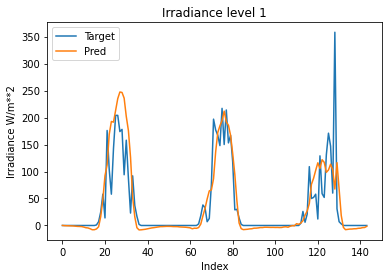

In [9]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

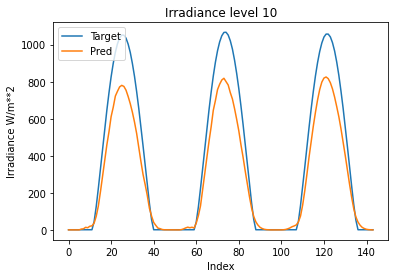

In [10]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Original Dataset
Scaled to -> \[0, 1]

### Preparing dataset

In [11]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=True, new_min = 0, new_max = 1)
df_test_uscd = read_csv("data/amarillo_norm_test.csv", scale=False)
df_test = read_csv("data/amarillo_norm_test.csv", scale=True, new_min = 0, new_max = 1)
targets = df_test["y0"].values
test_min = df_test_uscd['y0'].min()
test_max = df_test_uscd['y0'].max()

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_norm_train.csv . . .
Scaling data/amarillo_norm_test.csv . . .


### Training

In [12]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

5155/5155 [==============================] - 13s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0140 - val_mean_squared_error: 0.0140


### Testing

In [13]:
preds = model.predict(ds_test)
df_test['pred'] = preds

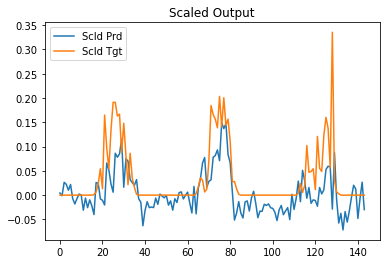

In [14]:
plt.plot(df_test['pred'][:48*3], label='Scld Prd')
plt.plot(df_test['y0'][:48*3], label='Scld Tgt')
plt.legend()
plt.title('Scaled Output')
plt.show()

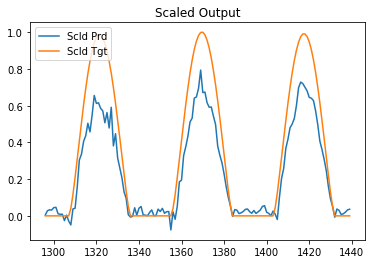

In [15]:
plt.plot(df_test['pred'][-48*3:], label='Scld Prd')
plt.plot(df_test['y0'][-48*3:], label='Scld Tgt')
plt.legend()
plt.title('Scaled Output')
plt.show()

In [16]:
scale_dataframe(df=df_test, cols=['y0', 'pred'], new_max=test_max, new_min=test_min)

In [18]:
targets = df_test['y0'].values
preds = df_test['pred'].values

In [19]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 11011.51811822049
MAE 93.57965939972135
SMAPE 0.6068822181614807


In [20]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

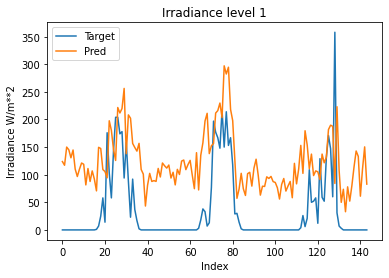

In [21]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

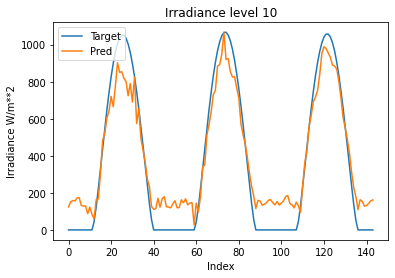

In [22]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Original Dataset
Scaled to -> \[-1, 1]

### Preparing dataset

In [4]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=True, new_min = -1, new_max = 1)
df_test_uscd = read_csv("data/amarillo_norm_test.csv", scale=False)
df_test = read_csv("data/amarillo_norm_test.csv", scale=True, new_min = -1, new_max = 1)
targets = df_test["y0"].values
test_min = df_test_uscd['y0'].min()
test_max = df_test_uscd['y0'].max()

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_norm_train.csv . . .
Scaling data/amarillo_norm_test.csv . . .


### Training

In [5]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

5155/5155 [==============================] - 12s 2ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0816 - val_mean_squared_error: 0.0816


### Testing

In [6]:
preds = model.predict(ds_test)
df_test['pred'] = preds

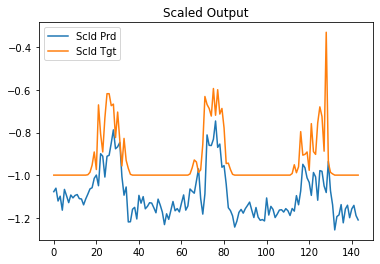

In [7]:
plt.plot(df_test['pred'][:48*3], label='Scld Prd')
plt.plot(df_test['y0'][:48*3], label='Scld Tgt')
plt.legend()
plt.title('Scaled Output')
plt.show()

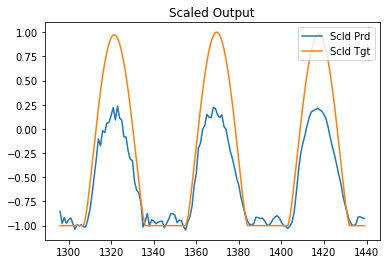

In [8]:
plt.plot(df_test['pred'][-48*3:], label='Scld Prd')
plt.plot(df_test['y0'][-48*3:], label='Scld Tgt')
plt.legend()
plt.title('Scaled Output')
plt.show()

In [9]:
scale_dataframe(df=df_test, cols=['y0', 'pred'], new_max=test_max, new_min=test_min)

In [48]:
targets = df_test['y0'].values
preds = df_test['pred'].values

In [50]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 16226.890784646255
MAE 113.41474181347424
num=array([128.31854248, 139.98374939,  96.97426605, ..., 249.49154663,
       240.92655945, 237.54763794])
den=array([128.31854248, 139.98374939,  96.97426605, ..., 249.49154663,
       240.92655945, 237.54763794])
sum=array([1., 1., 1., ..., 1., 1., 1.])
SMAPE 0.6248659105896136


<ipython-input-43-f4120e013be4>:6: RuntimeWarning: invalid value encountered in true_divide
  sum = np.where(den==0, 0, num / den)


In [51]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

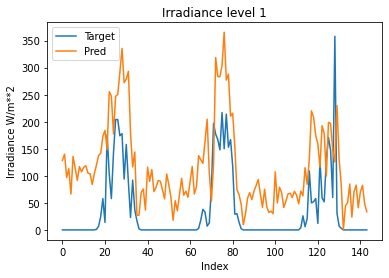

In [52]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

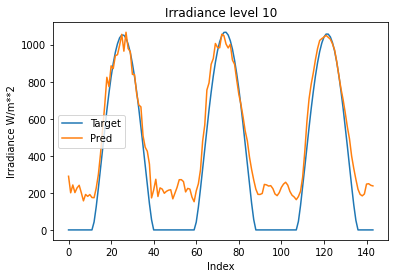

In [53]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Unscaled Differences Dataset

### Preparing dataset

In [54]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=False)
df_test = read_csv("data/amarillo_diff_test.csv", scale=False)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=False)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

### Training

In [55]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

5155/5155 [==============================] - 12s 2ms/step - loss: 4250.0273 - mean_squared_error: 4250.0273 - val_loss: 2515.4932 - val_mean_squared_error: 2515.4932


### Testing

In [56]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_unscaled = preds.copy()

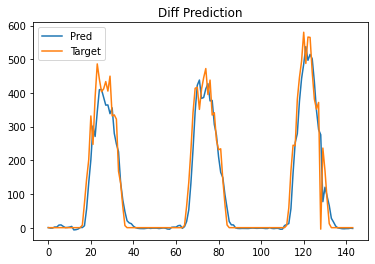

In [57]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

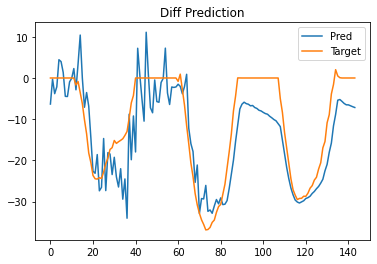

In [62]:
plt.plot(preds_temp[-48*3:], label='Pred')
plt.plot(targets[-48*3:], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [63]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 1894.7610465534938
MAE 21.136834602756085
num=array([0.27893767, 1.2715354 , 1.05570447, ..., 6.75897312, 6.96814966,
       7.16234493])
den=array([0.27893767, 1.2715354 , 1.05570447, ..., 6.75897312, 6.96814966,
       7.16234493])
sum=array([1., 1., 1., ..., 1., 1., 1.])
SMAPE 0.5825384737584938


In [64]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

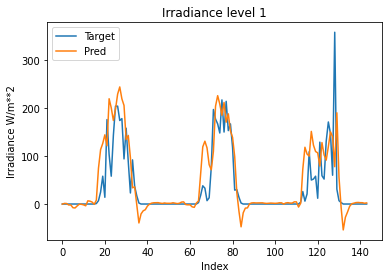

In [65]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

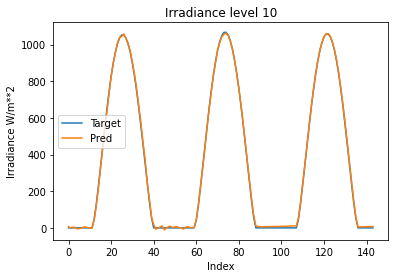

In [66]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Differences Dataset
Scaled -> [0, 1]

### Preparing dataset

In [67]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=True, new_min = 0, new_max = 1)
df_test = read_csv("data/amarillo_diff_test.csv", scale=True, new_min = 0, new_max = 1)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=False)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_diff_train.csv . . .
Scaling data/amarillo_diff_test.csv . . .


In [68]:
df_train['x0'].max()

1.0

In [69]:
df_train['x0'].min()

0.0

### Training

In [70]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

5155/5155 [==============================] - 12s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0031 - val_mean_squared_error: 0.0031


### Testing

In [71]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_unscaled = preds.copy()

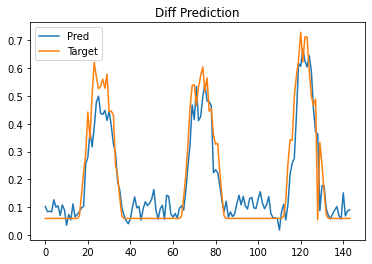

In [72]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

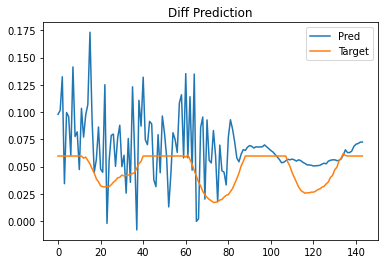

In [73]:
plt.plot(preds_temp[-48*3:], label='Pred')
plt.plot(targets[-48*3:], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [74]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 19196.67497984341
MAE 56.53657485019481
num=array([0.1027515 , 0.08397934, 0.08539937, ..., 0.07114024, 0.07240593,
       0.07254487])
den=array([0.1027515 , 0.08397934, 0.08539937, ..., 0.07114024, 0.07240593,
       0.07254487])
sum=array([1., 1., 1., ..., 1., 1., 1.])
SMAPE 0.6150021836526028


In [75]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

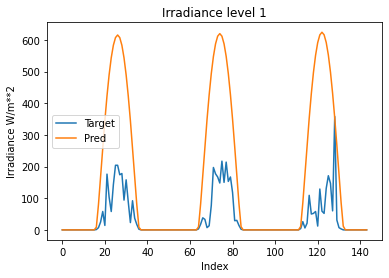

In [76]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

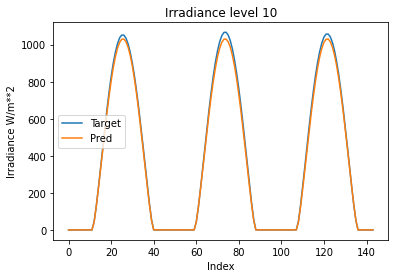

In [77]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Differences Dataset
Scaled -> [-1, 1]

### Preparing dataset

In [90]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=True, new_min = -1, new_max = 1)
df_test = read_csv("data/amarillo_diff_test.csv", scale=True, new_min = -1, new_max = 1)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=False)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values
print(df_train['x0'].max())
print(df_train['x0'].min())

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)
print(df_train['x0'].max())
print(df_train['x0'].min())
print(df_val['x0'].max())
print(df_val['x0'].min())

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_diff_train.csv . . .
Col x0, min -1.0, max1.0
Col x1, min -1.0, max1.0
Col x2, min -1.0, max1.0
Col x3, min -1.0, max1.0
Col x4, min -1.0, max1.0
Col x5, min -1.0, max1.0
Col x6, min -1.0, max1.0
Col x7, min -1.0, max1.0
Col x8, min -1.0, max1.0
Col x9, min -1.0, max1.0
Col x10, min -1.0, max1.0
Col x11, min -1.0, max1.0
Col x12, min -1.0, max1.0
Col x13, min -1.0, max1.0
Col x14, min -1.0, max1.0
Col x15, min -1.0, max1.0
Col x16, min -1.0, max1.0
Col x17, min -1.0, max1.0
Col x18, min -1.0, max1.0
Col x19, min -1.0, max1.0
Col x20, min -1.0, max1.0
Col x21, min -1.0, max1.0
Col x22, min -1.0, max1.0
Col x23, min -1.0, max1.0
Col x24, min -1.0, max1.0
Col x25, min -1.0, max1.0
Col x26, min -1.0, max1.0
Col x27, min -1.0, max1.0
Col x28, min -1.0, max1.0
Col x29, min -1.0, max1.0
Col x30, min -1.0, max1.0
Col x31, min -1.0, max1.0
Col x32, min -1.0, max1.0
Col x33, min -1.0, max1.0
Col x34, min -1.0, max1.0
Col x35, min -1.0, max1.0
Col x36, min -1.0, max1.0
Col x

In [87]:
df_train['x0'].max()

0.978025402902287

In [80]:
df_train['x0'].min()

-1.0

### Training

In [70]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

5155/5155 [==============================] - 12s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0031 - val_mean_squared_error: 0.0031


### Testing

In [71]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_unscaled = preds.copy()

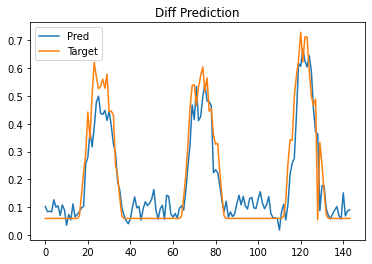

In [72]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

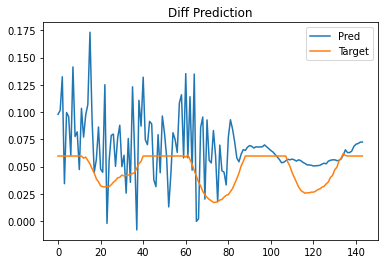

In [73]:
plt.plot(preds_temp[-48*3:], label='Pred')
plt.plot(targets[-48*3:], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [74]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 19196.67497984341
MAE 56.53657485019481
num=array([0.1027515 , 0.08397934, 0.08539937, ..., 0.07114024, 0.07240593,
       0.07254487])
den=array([0.1027515 , 0.08397934, 0.08539937, ..., 0.07114024, 0.07240593,
       0.07254487])
sum=array([1., 1., 1., ..., 1., 1., 1.])
SMAPE 0.6150021836526028


In [75]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

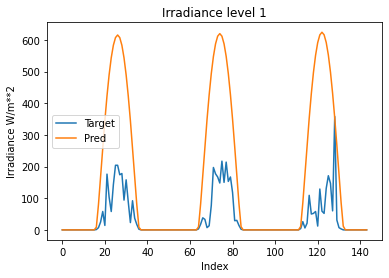

In [76]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

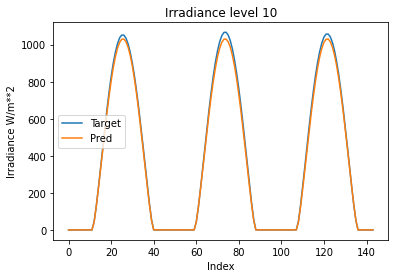

In [77]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Summary

In [54]:
print('Original Unscaled')
print(f"MSE {mse(targets, preds_unscaled)}")
print(f"MAE {mae(targets, preds_unscaled)}")
print(f"SMAPE {smape(targets, preds_unscaled)}")

Original Unscaled
MSE 74559.49801041631
MAE 149.61019791300194
SMAPE 0.8676888786767888


In [55]:
print('Original Scaled (0, 1)')
print(f"MSE {mse(targets, preds_scaled)}")
print(f"MAE {mae(targets, preds_scaled)}")
print(f"SMAPE {smape(targets, preds_scaled)}")

Original Scaled (0, 1)
MSE 75817.29209521071
MAE 151.36938054263203
SMAPE 0.8693709533191782


In [56]:
print('Original Scaled (-1, 1)')
print(f"MSE {mse(targets, preds_scaled_neg)}")
print(f"MAE {mae(targets, preds_scaled_neg)}")
print(f"SMAPE {smape(targets, preds_scaled_neg)}")

Original Scaled (-1, 1)
MSE 74979.40371993928
MAE 149.19719384872067
SMAPE 0.8688484356230695


In [57]:
print('Differences Unscaled')
print(f"MSE {mse(targets_orig, preds_diff_unscaled)}")
print(f"MAE {mae(targets_orig, preds_diff_unscaled)}")
print(f"SMAPE {smape(targets_orig, preds_diff_unscaled)}")

Differences Unscaled
MSE 1870.0894034898206
MAE 17.935002996370464
SMAPE 0.5781861089431134


In [58]:
print('Differences Scaled (0, 1)')
print(f"MSE {mse(targets_orig, preds_diff_scaled)}")
print(f"MAE {mae(targets_orig, preds_diff_scaled)}")
print(f"SMAPE {smape(targets_orig, preds_diff_scaled)}")

Differences Scaled (0, 1)
MSE 3614.424223858286
MAE 31.822405659789542
SMAPE 0.617983432390896


In [59]:
print('Differences Scaled (-1, 1)')
print(f"MSE {mse(targets_orig, preds_diff_scaled_neg)}")
print(f"MAE {mae(targets_orig, preds_diff_scaled_neg)}")
print(f"SMAPE {smape(targets_orig, preds_diff_scaled_neg)}")

Differences Scaled (-1, 1)
MSE 3473.368577092031
MAE 32.837405033836106
SMAPE 0.6163393960732045
